In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date as f_date
import scipy
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas_to_pybeh as pb
from cmlreaders import CMLReader, get_data_index
from plotting import *

In [2]:
# 1. If I want all FR1 and pyFR subjects
df = get_data_index("r1")
FR1_subs=df[df['experiment']=='FR1']['subject'].unique() # all FR1 subjects
exp = 'FR1' 

FR_subs=[]
FR_subs = list(FR1_subs)
print('Total number of FR subjects: ',len(FR_subs))

Total number of FR subjects:  281


In [57]:
evs = []
from tqdm.notebook import tqdm
for i, sub in enumerate(tqdm(FR_subs)):

#     print(sub, str(i/len(both)*100) + "% Done")
    exp = 'FR1'
    df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
    sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
    for sess in sessions:
        reader = CMLReader(sub, exp, sess)
        evs.append(reader.load('events'))
evs = pd.concat(evs)
word_evs = evs[evs.type=='WORD']
word_evs = word_evs[word_evs != -1]

In [58]:
def get_date(ms):
    date = f_date.fromtimestamp(ms/1000.0)
    return date

In [59]:
check_lists = word_evs.groupby(['subject', 'session']).list.nunique()
check_lists = check_lists[check_lists==12]
check_sess = check_lists.groupby('subject').count()
check_sess = check_sess[check_sess>1]
good_subs = check_sess.index
check_lists = check_lists.reset_index()
check_lists = check_lists[check_lists.subject.isin(good_subs)]
evs = []
for i, row in tqdm(check_lists.iterrows()):
    sub = row.subject
    sess = row.session
    
    exp = 'FR1'
    reader = CMLReader(sub, exp, sess)
    evs.append(reader.load('events'))
evs = pd.concat(evs, ignore_index=True)

In [93]:
evs['datetime'] = evs.mstime.apply(get_date)
shift = evs.groupby(['subject', 'session']).datetime.agg('min').diff().reset_index('session')
first_sess = evs.groupby(['subject']).session.agg('min')
# shift[shift == first_sess]
shift['min_sess'] = first_sess
shift.loc[shift['session'] == shift['min_sess'], 'datetime'] = ''
shift.drop('min_sess',1,inplace=True)
bad_shift = shift[shift.datetime == pd.Timedelta("0 days")]
print(bad_shift)
for i, row in bad_shift.reset_index().iterrows():
    bad_sub = row.subject
    bad_sess = row.session
    bad_evs = evs[(evs.subject==bad_sub) & (evs.session==bad_sess)].index
    evs.drop(bad_evs,inplace=True)
    # evs[(evs.subject.isinb(bad_shift.index)) & (evs.session.isin(bad_shift.session))]

Empty DataFrame
Columns: [session, datetime]
Index: []


r = 0.826176262195078, p = 1.1091701643591156e-07, n = 27


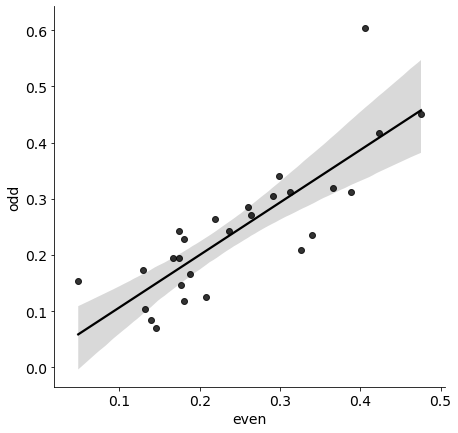

In [96]:
evs['even'] = evs['session']%2 == 0
word_evs = evs[evs.type == 'WORD']
word_evs= word_evs[~word_evs.list.isin([0, -999, -1])]

test_retest = word_evs.groupby(['subject', 'even']).recalled.mean().reset_index()
even_retest = test_retest[test_retest.even==True]
odd_retest = test_retest[test_retest.even==False]
odd_retest.rename(columns=dict(recalled='odd'), inplace=True)
odd_retest.set_index('subject', inplace=True)
even_retest.set_index('subject', inplace=True)
even_retest.drop('even', 1, inplace=True)
even_retest.rename(columns=dict(recalled='even'), inplace=True)
test_retest = even_retest.copy()
test_retest['odd'] = odd_retest.odd
set_axes()
test_retest.dropna(inplace=True)
sns.regplot(data = test_retest, x = 'even', y = 'odd', color = 'black')

r, p = scipy.stats.pearsonr(test_retest['even'], test_retest['odd'])
n = test_retest.shape[0]
print('r = {}, p = {}, n = {}'.format(r,p,n))
np.save('fr1_test_retest', [r,p,n])

In [30]:
find_halves = word_evs.groupby(['subject', 'session']).item_name.count()


In [31]:
find_halves

subject  session
R1001P   0          300
         1          300
R1002P   0          300
         1          300
R1003P   0          264
                   ... 
R1565T   0          130
R1569T   0          300
R1571T   0          300
R1572T   0           60
R1573T   0          112
Name: item_name, Length: 587, dtype: int64

In [78]:
check_dates = evs.groupby(['subject', 'session']).datetime.first().groupby(['subject']).diff().reset_index()
check_dates = check_dates[check_dates!=datetime.timedelta(0)].set_index('subject')

check_dates = check_dates[check_dates.groupby('subject').apply(lambda x: ~x.datetime.isna().all())]
check_dates

/usr/global/Anaconda/2019-10/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,session,datetime
subject,,
R1001P,0,NaT
R1001P,1,1 days 00:00:00
R1002P,0,NaT
R1002P,1,1 days 00:00:00
R1003P,0,NaT
...,...,...
R1542J,1,NaN
R1542J,2,1 days 00:00:00
R1542J,3,2 days 00:00:00
